In [41]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "serif"
plt.rcParams['hatch.linewidth'] = 1.5

dataset = ["STK","TAO","HPC","GAS","EM","FC"]

algo_color = {'NAIVE': 'grey',
              'SOP': '#4BACC6',
              'pMCSKY': '#1F497D',
              'OURS-Q': '#F79646',
              'OURS-D': '#9BBB59',
              'OURS': '#C0504D'}

algo_hatch = {'NAIVE': '||',
              'SOP': '++',
              'pMCSKY': 'xx',
              'OURS-Q': '--',
              'OURS-D': '//',
              'OURS': '\\\\\\'}

algo_line = {'NAIVE': '-',
              'SOP': '--',
              'pMCSKY': '-.',
              'OURS-Q': '--',
              'OURS-D': '--',
              'OURS': '-'}

algo_marker = {'NAIVE': '',
              'SOP': 's',
              'pMCSKY': '^',
              'OURS-Q': 'x',
              'OURS-D': 'x',
              'OURS': 'x'}


basic_linewidth = 3
algo_linewidth = {'NAIVE': basic_linewidth/2,
                  'SOP': basic_linewidth/2,
                  'pMCSKY': basic_linewidth/2,
                  'OURS-Q': basic_linewidth/2,
                  'OURS-D': basic_linewidth/2,
                  'OURS': basic_linewidth}

# Overall Bar Plot Parameters
barWidth = 0.75
FONTSIZE_TICK=13
FONTSIZE_XLABEL=18
FONTSIZE_YLABEL=13
intra_bar_space = 1.2
inter_bar_space = 2
figsize_overall=(10,2)
target_alg_overall = ['SOP','pMCSKY','OURS']

# Line Plot parameters
figsize_vp = (5,2)
target_alg_vp = ['SOP','pMCSKY','OURS']
FONTSIZE_TICK_vp=10
FONTSIZE_XLABEL_vp=12
FONTSIZE_YLABEL_vp=14

# stationarity Plot parameters
figsize_stationarity = (2,2)
target_alg_stationarity = ['SOP','pMCSKY','OURS']
FONTSIZE_TICK_stationarity=8
FONTSIZE_XLABEL_stationarity=12
FONTSIZE_YLABEL_stationarity=12

# Unified
barWidth_unified = 0.375
figsize_unified = (5,1)
target_alg_unified = ['NAIVE','SOP','pMCSKY','OURS-Q','OURS-D','OURS']
FONTSIZE_TICK_unified=7
FONTSIZE_XLABEL_unified=10
FONTSIZE_YLABEL_unified=7
intra_bar_space_unified = 1.3
inter_bar_space_unified = 2.1

In [42]:
def preprocessing(pathList):
    headerf = open(pathList[0]+".txt")
    header = headerf.readline()
    header = "\t".join(header.split())
    w=open("separated.csv",'w')
    w.write(header+"\n")
    for path in pathList:
        f=open(path+".txt",'r')
        i = -1
        for line in f.readlines():
            i += 1
            if (len(line.split())<9) or (i<1):
                continue
            tab_sep_line = "\t".join(line.split())
            w.write(tab_sep_line+"\n")

    w.close()
    dataframe = pd.read_csv(os.getcwd()+"/separated.csv", sep="\t")
    return dataframe   




In [43]:
df = preprocessing(dataset)
df.tail(20)

,Dataset,Queryset,ChgQRatio,Method,Time,AvgMem,PeakMem,#Out,#OutQ
248,FC,FC_Q10,0.1,OURS,164.14,16.9,105.0,5416,5991
249,FC,FC_Q100,0.0,NAIVE,92440.97,6.0,83.0,26017,36583
250,FC,FC_Q100,0.0,SOP,6906.65,235.7,327.0,26017,36583
251,FC,FC_Q100,0.0,pMCSKY,6488.66,195.2,286.0,26017,36583
252,FC,FC_Q100,0.0,OURS-Q,645.10,21.0,97.0,26017,36583
253,FC,FC_Q100,0.0,OURS-D,1919.78,21.0,97.0,26017,36583
254,FC,FC_Q100,0.0,OURS,1267.72,21.0,98.0,26017,36583
255,FC,FC_Q100,0.1,NAIVE,95029.51,6.0,83.0,63368,103743
256,FC,FC_Q100,0.1,SOP,47866.62,250.2,349.0,63368,103743
257,FC,FC_Q100,0.1,pMCSKY,46208.55,194.1,293.0,63368,103743


# Overall Performance
###### queryNumber=100, ChgQRatio>0, targetAlgorithm = SOP, pMCSKY, OURS

## Overall Cpu Time


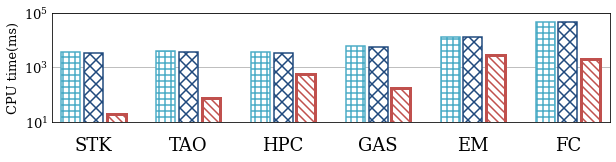

In [44]:
dataset_ = dataset.copy()
dataname = dataset_.pop()
graphdf = df.loc[(df["Dataset"]==dataname)&(df["Queryset"].str.contains(r"\_Q100$")) \
                 & (df['ChgQRatio']>0)].pivot(index="Dataset",columns="Method",values="Time")

for dataname in dataset_:
    graphdf = pd.concat([graphdf, df.loc[(df["Dataset"]==dataname)&(df["Queryset"].str.contains(r"\_Q100$")) & (df['ChgQRatio']==0)].pivot(index="Dataset",columns="Method",values="Time")])
graphdf = graphdf[target_alg_overall]

graphdf = graphdf.reindex(index=dataset)
fig = plt.figure(figsize=figsize_overall)
ax = fig.add_subplot(1,1,1)
xpositions = []
for i, algname in enumerate(target_alg_overall):
    xposition = np.arange(graphdf.shape[0])*barWidth*(len(target_alg_overall)+inter_bar_space) + barWidth*intra_bar_space*i
    center = (xposition[0]+xposition[-1])/2
    xpositions.append(xposition)
    ax.bar(xposition,graphdf.iloc[:,i].tolist(), color = "white", width=barWidth,\
           hatch=algo_hatch[algname], edgecolor=algo_color[algname],\
           linewidth=algo_linewidth[algname], zorder=2)
ax.grid(b=True,which="major",axis='y',zorder=0)
ax.set_yscale("log")
ax.set_xlabel("")
ax.set_ylabel('CPU time(ms)', fontsize=FONTSIZE_YLABEL)

ax.set_xlim([-barWidth,xposition[-1]+barWidth])
ax.set_ylim([10,100000])
plt.yticks([10,1e3,1e5])
xpositions=np.array(xpositions)
plt.xticks(np.mean(xpositions,axis=0),dataset)

# remove ticks
ax.tick_params(axis ='both', which ='both', length = 0)
ax.tick_params(axis ='x', labelsize=FONTSIZE_XLABEL, pad=15)
ax.tick_params(axis ='y', labelsize=FONTSIZE_TICK)
# rotate ticks
ax.tick_params(axis ='x', rotation = 0)
plt.savefig('Overall_CpuTime.pdf', bbox_inches='tight', format='pdf')

## Overall Peak Memory

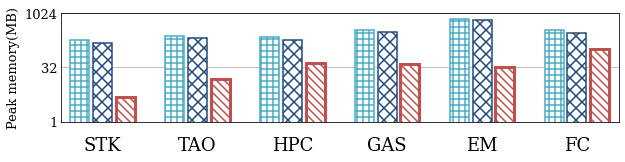

In [45]:
dataset_ = dataset.copy()
dataname = dataset_.pop()
graphdf = df.loc[(df["Dataset"]==dataname)&(df["Queryset"].str.contains(r"\_Q100$")) \
                 & (df['ChgQRatio']>0)].pivot(index="Dataset",columns="Method",values="PeakMem")

for dataname in dataset_:
    graphdf = pd.concat([graphdf, df.loc[(df["Dataset"]==dataname)&(df["Queryset"].str.contains(r"\_Q100$")) \
                                         & (df['ChgQRatio']==0)].pivot(index="Dataset",columns="Method",values="PeakMem")])
graphdf = graphdf[target_alg_overall]

graphdf = graphdf.reindex(index=dataset)

fig = plt.figure(figsize=figsize_overall)
ax = fig.add_subplot(1,1,1)
xpositions = []
for i, algname in enumerate(target_alg_overall):
    xposition = np.arange(graphdf.shape[0])*barWidth*(len(target_alg_overall)+inter_bar_space) + barWidth*intra_bar_space*i
    center = (xposition[0]+xposition[-1])/2
    xpositions.append(xposition)
    ax.bar(xposition,graphdf.iloc[:,i].tolist(), color = "white", width=barWidth,\
           hatch=algo_hatch[algname], edgecolor=algo_color[algname], \
           linewidth=algo_linewidth[algname], zorder=2)
ax.grid(b=True,which="major",axis='y',zorder=0)
ax.set_yscale("log",basey=2)
ax.set_xlabel("")
ax.set_ylabel('Peak memory(MB)', fontsize=FONTSIZE_YLABEL)
ax.set_xlim([-barWidth,xposition[-1]+barWidth])
ax.set_ylim([1,1024])
plt.yticks([1,32,1024])
ax.set_yticklabels(['1','32','1024'])
xpositions=np.array(xpositions)
plt.xticks(np.mean(xpositions,axis=0),dataset)

# remove ticks
ax.tick_params(axis='both', which ='both', length = 0)
ax.tick_params(axis='x', labelsize=FONTSIZE_XLABEL, pad=15)
ax.tick_params(axis='y', labelsize=FONTSIZE_TICK)
# rotate ticks
ax.tick_params(axis ='x', rotation = 0)

plt.savefig('Overall_PeakMem.pdf', bbox_inches='tight', format='pdf')


# Overall Legend

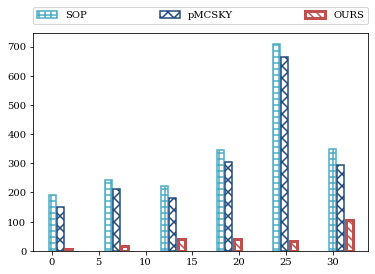

In [46]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
xpositions = []
bars = []
for i, algname in enumerate(target_alg_overall):
    xposition = np.arange(graphdf.shape[0])*barWidth*(graphdf.shape[0]+inter_bar_space) + barWidth*intra_bar_space*i
    center = (xposition[0]+xposition[-1])/2
    xpositions.append(xposition)
    bar = ax.bar(xposition,graphdf.iloc[:,i].tolist(), color = "white", width=barWidth,\
               hatch=algo_hatch[algname], edgecolor=algo_color[algname], \
               linewidth=algo_linewidth[algname], zorder=2)
    bars.append(bar)

legend = ax.legend(handles=bars,labels=target_alg_overall,\
                   bbox_to_anchor=(0., 1.02, 1., .102), loc='upper center',\
                   ncol=len(target_alg_overall), mode="expand", borderaxespad=0.)

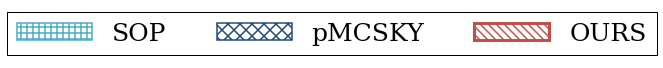

In [47]:
figsize = (10, 1)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)
# add the legend from the previous axes
ax_leg.legend(handles=bars,labels=target_alg_overall, loc='center', ncol=len(target_alg_overall), \
                facecolor='white', framealpha=1,edgecolor='black', fancybox = False,handlelength =3,\
              prop={'size':25}
              )
# hide the axes frame and the x/y labels
ax_leg.axis('off')
fig_leg.savefig('Overall_Legend.pdf', bbox_inches='tight', format='pdf')

# Changing the number of queries - CPU time, Peak memory
###### ChgQRatio>0, targetAlgorithm = ALL
## CPU time

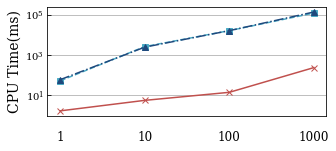

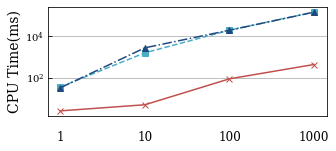

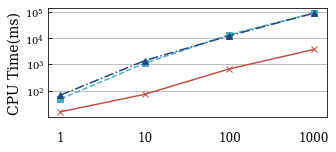

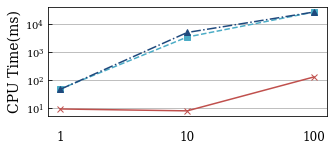

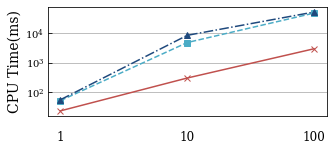

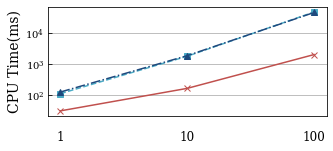

In [48]:
for dataname in dataset:
    graphdf = df.loc[(df["Dataset"]==dataname) & (df['ChgQRatio']>0)]\
        .pivot(index="Queryset",columns="Method",values="Time")

    graphdf.reindex(index=dataset)
    graphdf.head(19)
    fig = plt.figure(figsize=figsize_vp)
    ax = fig.add_subplot(1,1,1)

    for i, algname in enumerate(target_alg_vp):
        ax.plot(graphdf[algname], linestyle=algo_line[algname], marker=algo_marker[algname], color=algo_color[algname])
    ax.set_yscale("log")
    ax.set_xlabel("")
    ax.set_ylabel('CPU Time(ms)', fontsize=FONTSIZE_YLABEL_vp)
    ax.grid(b=True,which="major",axis='y',zorder=0)
    ax.set_xticklabels([1,10,100,1000])
    ax.tick_params(axis='x', which ='both', length = 0)
    ax.tick_params(axis='x', labelsize=FONTSIZE_XLABEL_vp, pad=15)
    ax.tick_params(axis='y', labelsize=FONTSIZE_TICK_vp)
    ax.tick_params(axis='y', which ='minor', length = 0)
    ax.tick_params(axis='y', which ='major', direction='in')
    plt.savefig('QueryNum_'+dataname+'_CpuTime.pdf', bbox_inches='tight', format='pdf')

## Peak memory

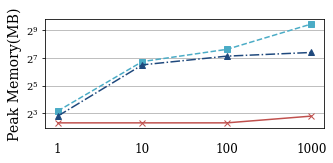

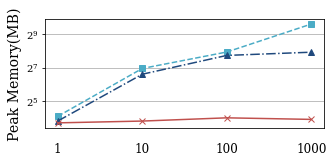

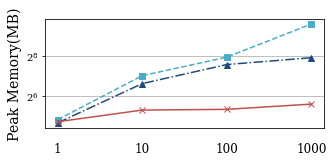

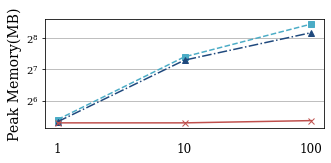

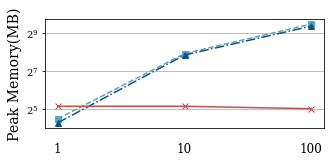

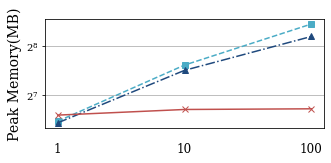

In [49]:
for dataname in dataset:
    graphdf = df.loc[(df["Dataset"]==dataname) & (df['ChgQRatio']>0)]\
        .pivot(index="Queryset",columns="Method",values="PeakMem")

    graphdf.reindex(index=dataset)

    fig = plt.figure(figsize=figsize_vp)
    ax = fig.add_subplot(1,1,1)

    for i, algname in enumerate(target_alg_vp):
        ax.plot(graphdf[algname], linestyle=algo_line[algname], marker=algo_marker[algname], color=algo_color[algname])
    ax.set_yscale("log",basey=2)
    ax.set_xlabel("")
    ax.set_ylabel('Peak Memory(MB)', fontsize=FONTSIZE_YLABEL_vp)
    ax.grid(b=True,which="major",axis='y',zorder=0)
    ax.set_xticklabels([1,10,100,1000])
    ax.tick_params(axis='x', which ='both', length = 0)
    ax.tick_params(axis='x', labelsize=FONTSIZE_XLABEL_vp, pad=15)
    ax.tick_params(axis='y', labelsize=FONTSIZE_TICK_vp)
    plt.savefig('QueryNum_'+dataname+'_PeakMem.pdf', bbox_inches='tight', format='pdf')

# Changing the stationarity of queries - CPU time, Peak memory
###### numQuery=100, targetAlgorithm = ALL

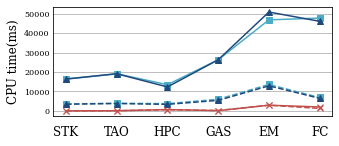

In [50]:
graphdf_stationary = df.loc[(df['ChgQRatio']==0) & (df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="Dataset",columns="Method",values="Time").reindex(dataset)
graphdf_dynamic = df.loc[(df['ChgQRatio']>0) & (df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="Dataset",columns="Method",values="Time").reindex(dataset)

fig = plt.figure(figsize=figsize_vp)
ax = fig.add_subplot(1,1,1)
for i, algname in enumerate(target_alg_stationarity):
    ax.plot(graphdf_stationary[algname], linestyle='--', marker=algo_marker[algname], color=algo_color[algname])
    ax.plot(graphdf_dynamic[algname], linestyle='-', marker=algo_marker[algname], color=algo_color[algname])
ax.grid(b=True,which="major",axis='y',zorder=0)
ax.set_xlabel("")
ax.set_ylabel('CPU time(ms)', fontsize=FONTSIZE_YLABEL_stationarity)
# ax.set_xlim([-barWidth,xposition[-1]+barWidth])
# ax.set_ylim([1,1024])
# plt.yticks([1,32,1024])
# ax.set_yticklabels(['1','32','1024'])
# ax.set_yscale("log")
ax.tick_params(axis='both', which ='both', length = 0)
ax.tick_params(axis='x', labelsize=FONTSIZE_XLABEL_stationarity)
ax.tick_params(axis='y', labelsize=FONTSIZE_TICK_stationarity)
# rotate ticks
ax.tick_params(axis ='x', rotation = 0, pad=10)
plt.savefig('Stationarity_CpuTime.pdf', bbox_inches='tight', format='pdf')

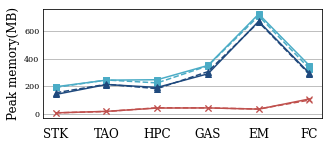

In [51]:
graphdf_stationary = df.loc[(df['ChgQRatio']==0) & (df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="Dataset",columns="Method",values="PeakMem").reindex(dataset)
graphdf_dynamic = df.loc[(df['ChgQRatio']>0) & (df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="Dataset",columns="Method",values="PeakMem").reindex(dataset)

fig = plt.figure(figsize=figsize_vp)
ax = fig.add_subplot(1,1,1)
for i, algname in enumerate(target_alg_stationarity):
    ax.plot(graphdf_stationary[algname], linestyle='--', marker=algo_marker[algname], color=algo_color[algname])
    ax.plot(graphdf_dynamic[algname], linestyle='-', marker=algo_marker[algname], color=algo_color[algname])
ax.grid(b=True,which="major",axis='y',zorder=0)
ax.set_xlabel("")
ax.set_ylabel('Peak memory(MB)', fontsize=FONTSIZE_YLABEL_stationarity)
# ax.set_xlim([-barWidth,xposition[-1]+barWidth])
# ax.set_ylim([1,1024])
# plt.yticks([1,32,1024])
# ax.set_yticklabels(['1','32','1024'])

ax.tick_params(axis='both', which ='both', length = 0)
ax.tick_params(axis='x', labelsize=FONTSIZE_XLABEL_stationarity)
ax.tick_params(axis='y', labelsize=FONTSIZE_TICK_stationarity)
# rotate ticks
ax.tick_params(axis ='x', rotation = 0, pad=10)
plt.savefig('Stationarity_PeakMem.pdf', bbox_inches='tight', format='pdf')

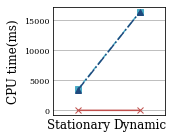

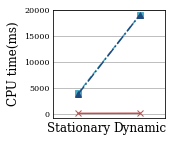

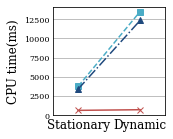

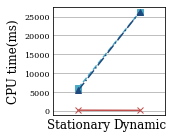

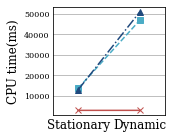

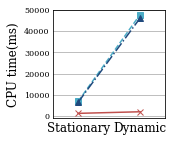

In [52]:

for dataname in dataset:
    graphdf_nochange = df.loc[(df["Dataset"]==dataname) & (df['ChgQRatio']==0) & \
        (df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="ChgQRatio",columns="Method",values="Time")
    graphdf_change = df.loc[(df["Dataset"]==dataname) & (df['ChgQRatio']>0) & \
            (df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="ChgQRatio",columns="Method",values="Time")
    graphdf = pd.concat([graphdf_nochange,graphdf_change])
    graphdf.index=["Stationary",'Dynamic']
    graphdf = graphdf[target_alg_stationarity]
    fig = plt.figure(figsize=figsize_stationarity)
    ax = fig.add_subplot(1,1,1)
    for i, algname in enumerate(target_alg_stationarity):
        ax.plot(graphdf[algname], linestyle=algo_line[algname], marker=algo_marker[algname], color=algo_color[algname])
    ax.grid(b=True,which="major",axis='y',zorder=0)
    ax.set_xlabel("")
    ax.set_ylabel('CPU time(ms)', fontsize=FONTSIZE_YLABEL_stationarity)
    ax.set_xlim([-0.4,1.4])
    # ax.set_ylim([1,1024])
    # plt.yticks([1,32,1024])
    # ax.set_yticklabels(['1','32','1024'])
    # xpositions=np.array(xpositions)
    # plt.xticks(np.mean(xpositions,axis=0),["Stationary",'Dynamic'])

    # TODO: Put pattern in the bar graph
    # remove ticks
    ax.tick_params(axis='both', which ='both', length = 0)
    ax.tick_params(axis='x', labelsize=FONTSIZE_XLABEL_stationarity)
    ax.tick_params(axis='y', labelsize=FONTSIZE_TICK_stationarity)
    # rotate ticks
    ax.tick_params(axis ='x', rotation = 0)

    plt.savefig('Stationarity_'+dataname+'_CpuTime.pdf', bbox_inches='tight', format='pdf')

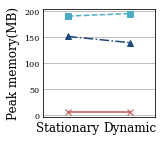

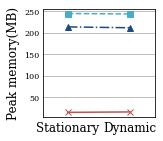

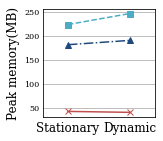

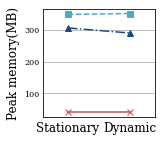

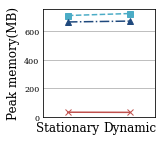

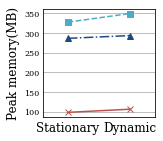

In [53]:

for dataname in dataset:
    graphdf_nochange = df.loc[(df["Dataset"]==dataname) & (df['ChgQRatio']==0) & \
        (df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="ChgQRatio",columns="Method",values="PeakMem")
    graphdf_change = df.loc[(df["Dataset"]==dataname) & (df['ChgQRatio']>0) & \
            (df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="ChgQRatio",columns="Method",values="PeakMem")
    graphdf = pd.concat([graphdf_nochange,graphdf_change])
    graphdf.index=["Stationary",'Dynamic']
    graphdf = graphdf[target_alg_stationarity]
    fig = plt.figure(figsize=figsize_stationarity)
    ax = fig.add_subplot(1,1,1)
    for i, algname in enumerate(target_alg_stationarity):
        ax.plot(graphdf[algname], linestyle=algo_line[algname], marker=algo_marker[algname], color=algo_color[algname])
    ax.grid(b=True,which="major",axis='y',zorder=0)
    ax.set_xlabel("")
    ax.set_ylabel('Peak memory(MB)', fontsize=FONTSIZE_YLABEL_stationarity)
    ax.set_xlim([-0.4,1.4])
    # ax.set_ylim([1,1024])
    # plt.yticks([1,32,1024])
    # ax.set_yticklabels(['1','32','1024'])
    # xpositions=np.array(xpositions)
    # plt.xticks(np.mean(xpositions,axis=0),["Stationary",'Dynamic'])

    # TODO: Put pattern in the bar graph
    # remove ticks
    ax.tick_params(axis='both', which ='both', length = 0)
    ax.tick_params(axis='x', labelsize=FONTSIZE_XLABEL_stationarity)
    ax.tick_params(axis='y', labelsize=FONTSIZE_TICK_stationarity)
    # rotate ticks
    ax.tick_params(axis ='x', rotation = 0)

    plt.savefig('Stationarity_'+dataname+'_PeakMem.pdf', bbox_inches='tight', format='pdf')

## Stationary Legend

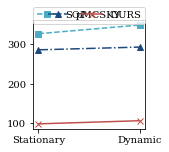

In [54]:
graphdf_nochange = df.loc[(df["Dataset"]==dataname) & (df['ChgQRatio']==0) & \
        (df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="ChgQRatio",columns="Method",values="PeakMem")
graphdf_change = df.loc[(df["Dataset"]==dataname) & (df['ChgQRatio']>0) & \
        (df["Queryset"].str.contains(r"\_Q100$"))].pivot(index="ChgQRatio",columns="Method",values="PeakMem")
graphdf = pd.concat([graphdf_nochange,graphdf_change])
graphdf.index=["Stationary",'Dynamic']
graphdf = graphdf[target_alg_stationarity]
fig = plt.figure(figsize=figsize_stationarity)
ax = fig.add_subplot(1,1,1)
plots = []
for i, algname in enumerate(target_alg_stationarity):
    plot = ax.plot(graphdf[algname], linestyle=algo_line[algname], marker=algo_marker[algname], color=algo_color[algname])
    plots += plot
# legend = ax.legend(handles=plots,labels=target_alg_stationarity)

legend = ax.legend(handles=plots,labels=target_alg_stationarity,\
                   bbox_to_anchor=(0., 1.02, 1., .102), loc='upper center',\
                   ncol=len(target_alg_stationarity), mode="expand", borderaxespad=0.)

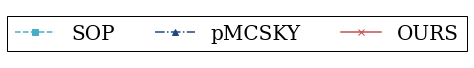

In [55]:
figsize = (7, 1)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)
# add the legend from the previous axes

ax_leg.legend(handles=plots,labels=target_alg_stationarity, loc='center', ncol=len(target_alg_stationarity), \
                facecolor='white', framealpha=1,edgecolor='black', fancybox = False,handlelength =2,\
               prop={'size':20})
# hide the axes frame and the x/y labels
ax_leg.axis('off')
fig_leg.savefig('Stationarity_Legend.pdf', bbox_inches='tight', format='pdf')


# Unified Grouping

In [56]:
plt.rcParams['hatch.linewidth'] = 0.75

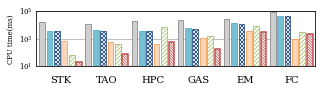

In [57]:
dataset_ = dataset.copy()
dataname = dataset_.pop()
graphdf = df.loc[(df["Dataset"]==dataname)&(df["Queryset"].str.contains(r"\_Q100$")) \
                 & (df['ChgQRatio']>0)].pivot(index="Dataset",columns="Method",values="Time")

for dataname in dataset_:
    graphdf = pd.concat([graphdf, df.loc[(df["Dataset"]==dataname)&(df["Queryset"].str.contains(r"\_Q100$")) & (df['ChgQRatio']==0)].pivot(index="Dataset",columns="Method",values="Time")])
graphdf = graphdf[target_alg_unified]

graphdf = graphdf.reindex(index=dataset)
fig = plt.figure(figsize=figsize_unified)
ax = fig.add_subplot(1,1,1)
xpositions = []
for i, algname in enumerate(target_alg_unified):
    xposition = np.arange(graphdf.shape[0])*barWidth_unified*(len(target_alg_unified)+inter_bar_space_unified) + barWidth_unified*intra_bar_space_unified*i
    center = (xposition[0]+xposition[-1])/2
    xpositions.append(xposition)
    ax.bar(xposition,graphdf.iloc[:,i].tolist(), color = "white", width=barWidth_unified,\
           hatch=algo_hatch[algname]*3, edgecolor=algo_color[algname],\
           linewidth=algo_linewidth[algname]/2, zorder=2)
ax.grid(b=True,which="major",axis='y',zorder=0)
ax.set_yscale("log")
ax.set_xlabel("")
ax.set_ylabel('CPU time(ms)', fontsize=FONTSIZE_YLABEL_unified)

ax.set_xlim([-barWidth_unified,xposition[-1]+barWidth_unified])
ax.set_ylim([10,100000])
plt.yticks([10,1e3,1e5])
xpositions=np.array(xpositions)
plt.xticks(np.mean(xpositions,axis=0),dataset)

# remove ticks
ax.tick_params(axis ='both', which ='both', length = 0)
ax.tick_params(axis ='x', labelsize=FONTSIZE_XLABEL_unified, pad=10)
ax.tick_params(axis ='y', labelsize=FONTSIZE_TICK_unified)
# rotate ticks
ax.tick_params(axis ='x', rotation = 0)
plt.savefig('Unified_CpuTime.pdf', bbox_inches='tight', format='pdf')


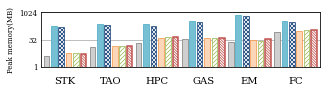

In [58]:
dataset_ = dataset.copy()
dataname = dataset_.pop()
graphdf = df.loc[(df["Dataset"]==dataname)&(df["Queryset"].str.contains(r"\_Q100$")) \
                 & (df['ChgQRatio']>0)].pivot(index="Dataset",columns="Method",values="PeakMem")

for dataname in dataset_:
    graphdf = pd.concat([graphdf, df.loc[(df["Dataset"]==dataname)&(df["Queryset"].str.contains(r"\_Q100$")) \
                                         & (df['ChgQRatio']==0)].pivot(index="Dataset",columns="Method",values="PeakMem")])
graphdf = graphdf[target_alg_unified]

graphdf = graphdf.reindex(index=dataset)

fig = plt.figure(figsize=figsize_unified)
ax = fig.add_subplot(1,1,1)
xpositions = []
for i, algname in enumerate(target_alg_unified):
    xposition = np.arange(graphdf.shape[0])*barWidth_unified*(len(target_alg_unified)+inter_bar_space_unified) + barWidth_unified*intra_bar_space_unified*i
    center = (xposition[0]+xposition[-1])/2
    xpositions.append(xposition)
    ax.bar(xposition,graphdf.iloc[:,i].tolist(), color = "white", width=barWidth_unified,\
               hatch=algo_hatch[algname]*3, edgecolor=algo_color[algname],\
               linewidth=algo_linewidth[algname]/2, zorder=2)
ax.grid(b=True,which="major",axis='y',zorder=0)
ax.set_yscale("log",basey=2)
ax.set_xlabel("")
ax.set_ylabel('Peak memory(MB)', fontsize=FONTSIZE_YLABEL_unified)
ax.set_xlim([-barWidth_unified,xposition[-1]+barWidth_unified])
ax.set_ylim([1,1024])
plt.yticks([1,32,1024])
ax.set_yticklabels(['1','32','1024'])
xpositions=np.array(xpositions)
plt.xticks(np.mean(xpositions,axis=0),dataset)

# remove ticks
ax.tick_params(axis='both', which ='both', length = 0)
ax.tick_params(axis='x', labelsize=FONTSIZE_XLABEL_unified, pad=10)
ax.tick_params(axis='y', labelsize=FONTSIZE_TICK_unified)
# rotate ticks
ax.tick_params(axis ='x', rotation = 0)

plt.savefig('Unified_PeakMem.pdf', bbox_inches='tight', format='pdf')

## Unified Legend

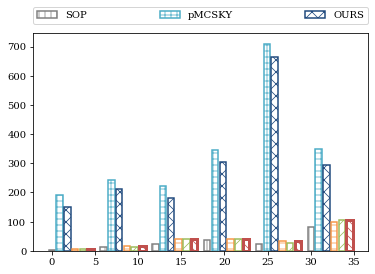

In [59]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
xpositions = []
bars = []
for i, algname in enumerate(target_alg_unified):
    xposition = np.arange(graphdf.shape[0])*barWidth*(graphdf.shape[0]+inter_bar_space) + barWidth*intra_bar_space*i
    center = (xposition[0]+xposition[-1])/2
    xpositions.append(xposition)
    bar = ax.bar(xposition,graphdf.iloc[:,i].tolist(), color = "white", width=barWidth,\
               hatch=algo_hatch[algname], edgecolor=algo_color[algname], \
               linewidth=algo_linewidth[algname], zorder=2)
    bars.append(bar)

legend = ax.legend(handles=bars,labels=target_alg_overall,\
                   bbox_to_anchor=(0., 1.02, 1., .102), loc='upper center',\
                   ncol=len(target_alg_overall), mode="expand", borderaxespad=0.)

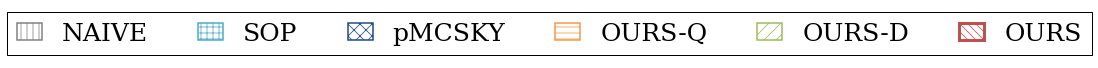

In [60]:
figsize = (14, 1)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)
# add the legend from the previous axes
ax_leg.legend(handles=bars,labels=target_alg_unified, loc='center', ncol=len(target_alg_unified), \
                facecolor='white', framealpha=1,edgecolor='black', fancybox = False,handlelength =1,\
              prop={'size':25}
              )
# hide the axes frame and the x/y labels
ax_leg.axis('off')
fig_leg.savefig('Unified_Legend.pdf', bbox_inches='tight', format='pdf')
